Simpact/MaxART: who gets treated where
--------------------------------------
This notebook shows that persons get treated or receive monitoring at the nearest health facility.

In [1]:
%matplotlib inline
import pysimpactcyan
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# First, we'll need to tell the Simpact simulation engine to use the MaxART-specific simulation
simpact = pysimpactcyan.PySimpactCyan()
simpact.setSimulationPrefix("maxart")

Setting data directory to /usr/local/share/simpact-cyan/


In [3]:
# Let's run a simulation with a fair amount of people, but limit the fraction of the population
# that anyone can see, to make the simulation advance faster. We'll also write the facility
# positions to a file, for plotting purposes later on
cfg = { "population.nummen": 2000,
        "population.numwomen": 2000,
        "population.eyecap.fraction": 0.05,
        "facilities.outfile.facilityxypos": "${SIMPACT_OUTPUT_PREFIX}facilitypositions.csv" }
r = simpact.run(cfg, "/tmp/simptest")

Using identifier 'maxart-2016-03-09-07-58-46_11340_c0TKXil1-'
Results will be stored in directory '/tmp/simptest'
Running simpact executable...
Done.

# read seed from /dev/urandom
# Using seed 479701877
# WARNING! Ignoring negative values when reading /usr/local/share/simpact-cyan/SWZ10adjv4.tif
# Performing extra check on read configuration parameters
# WARNING: ignoring consistency check for config key facilities.geo.coords (config value is '/usr/local/share/simpact-cyan/maxart-facilities.csv')
# WARNING: ignoring consistency check for config key facilities.randomization (config value is '/usr/local/share/simpact-cyan/maxart-randomization.csv')
# WARNING: ignoring consistency check for config key person.geo.dist2d.discrete.densfile (config value is '/usr/local/share/simpact-cyan/SWZ10adjv4.tif')
# WARNING: ignoring consistency check for config key person.geo.dist2d.discrete.maskfile (config value is '/usr/local/share/simpact-cyan/hhohho_mask.tiff')
# WARNING: ignoring consistency ch

In [4]:
# Here we'll inspect the event log for monitoring events. As extra arguments on such a line,
# the place where the monitoring takes place is written. Bookkeeping is then performed so that
# the person's X and Y coordinates are associated to that particular facility.

persons = pd.read_csv(r["logpersons"])

facilityNames = pd.read_csv(r["logsteps"]).columns[1:]
facilityTreatments = { }
for i in facilityNames:
    facilityTreatments[i] = { "x": [], "y": []}
    
numMonitoring = 0
with open(r["logevents"],"rt") as f:
    l = f.readline()
    while l:
        l = l.split(",")
        if l[1] == "monitoring":
            numMonitoring += 1
            facName = l[13]
            personId = int(l[3])
            personInfo = persons[persons["ID"] == personId]
            x, y = float(personInfo["XCoord"]), float(personInfo["YCoord"])
            facilityTreatments[facName]["x"].append(x)
            facilityTreatments[facName]["y"].append(y)
        l = f.readline()


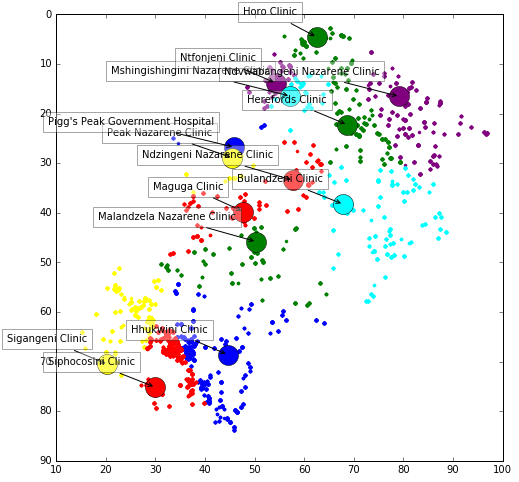

In [5]:
# Here we plot the facilities, together with the locations of people treated
# or monitored there.

# First we'll assign colors to facilities
colors = [ "red", "green", "blue", "yellow", "purple", "cyan" ]
colIdx = 0
for n in facilityTreatments:
    facilityTreatments[n]["color"] = colors[colIdx%len(colors)]
    colIdx += 1

plt.figure(1, figsize=(8,8))

# Then, for each facility we'll add markers for the locations of the persons
# that are treated there, and we'll draw the location of the facility itself
# as a large circle
facPos = pd.read_csv(r["facilityxypos"])
for n in facilityTreatments:
    color = facilityTreatments[n]["color"]
    facility = facPos[facPos["Facility name"] == n]

    plt.plot(facilityTreatments[n]["x"], facilityTreatments[n]["y"], '.', color=color)
    plt.plot(facility["XCoord"], facility["YCoord"], 'o', color=color, markersize=20)

# Let's add some labels
for label, x, y in zip(facPos["Facility name"], facPos["XCoord"], facPos["YCoord"]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'square,pad=0.5', fc = 'white', alpha = 0.35),
        arrowprops = dict(arrowstyle = '->')
    )
    
plt.gca().set_aspect("equal")
plt.gca().invert_yaxis()